# TitTok Sentiment Analysis -- Joseph Kim, Dec 2024

Import libraries

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import wordcloud
import warnings
from sklearn.model_selection import train_test_split
import string
import re
from textblob import TextBlob

Data cleaning and preprocessing

In [52]:
df = pd.read_csv('tiktok_data.csv') # Came from tiktok_webscraper.py

In [53]:
df.head()

,Title,Likes,Comments,Shares,Favorites
0,Georgie Cooper is always surprising.🤣🤣🤣,2M,2399,38.9K,143.6K
1,Physics,22.8K,96,315,1164
2,Man dumped via text for predicting election 💔🇺🇸🤣,1.8M,10.1K,128.3K,104.2K
3,Cops Get Destroyed For Unlawful Detainment! 1s...,85.4K,2973,915,6813
4,Po’ baby 🥲,680.9K,2515,10.6K,16.6K


In [54]:
missing_values = df.isnull().sum() # no missing values
missing_values

Title        0
Likes        0
Comments     0
Shares       0
Favorites    0
dtype: int64

In [55]:
# brief function to remove the B's, M's and K's from values 
def convert_to_numeric(value):
    if "M" in value:
        value = float(value.strip("M")) * 1_000_000
    elif "K" in value:
        value = float(value.strip("K")) * 1_000
    else:
        value = float(value)
    return value

In [56]:
df['Likes'] = df['Likes'].apply(convert_to_numeric)
df['Comments'] = df['Comments'].apply(convert_to_numeric)
df['Shares'] = df['Shares'].apply(convert_to_numeric)
df['Favorites'] = df['Favorites'].apply(convert_to_numeric) # should note that 'favorites' is actually the 'save' video feature

In [57]:
df.head()

,Title,Likes,Comments,Shares,Favorites
0,Georgie Cooper is always surprising.🤣🤣🤣,2000000.0,2399.0,38900.0,143600.0
1,Physics,22800.0,96.0,315.0,1164.0
2,Man dumped via text for predicting election 💔🇺🇸🤣,1800000.0,10100.0,128300.0,104200.0
3,Cops Get Destroyed For Unlawful Detainment! 1s...,85400.0,2973.0,915.0,6813.0
4,Po’ baby 🥲,680900.0,2515.0,10600.0,16600.0


### Creating Visualizations of Data: EDA

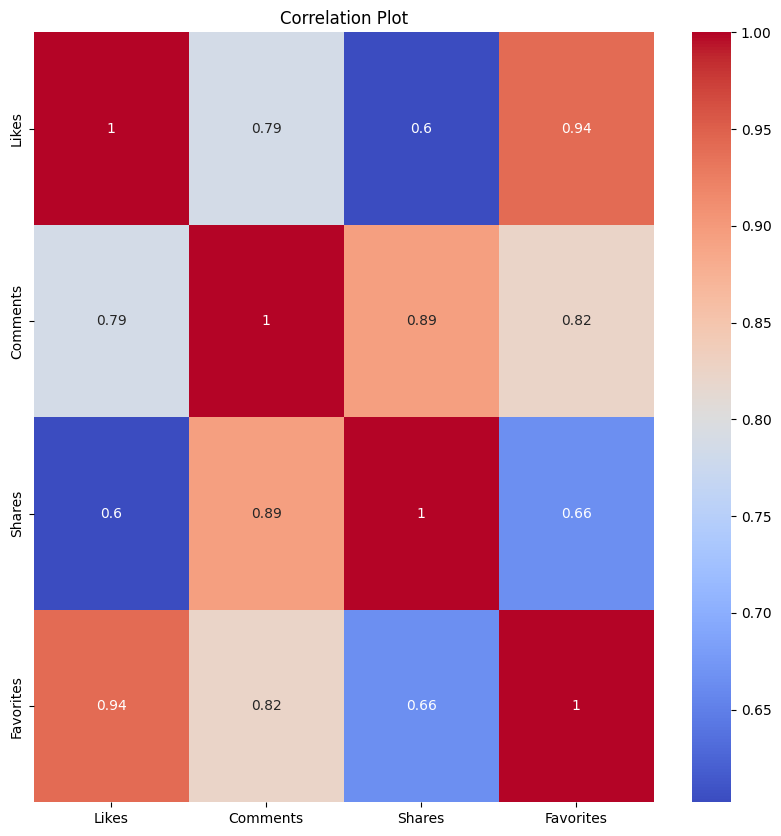

In [58]:
corr_matrix = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
ax.set_title('Correlation Plot')
plt.show()

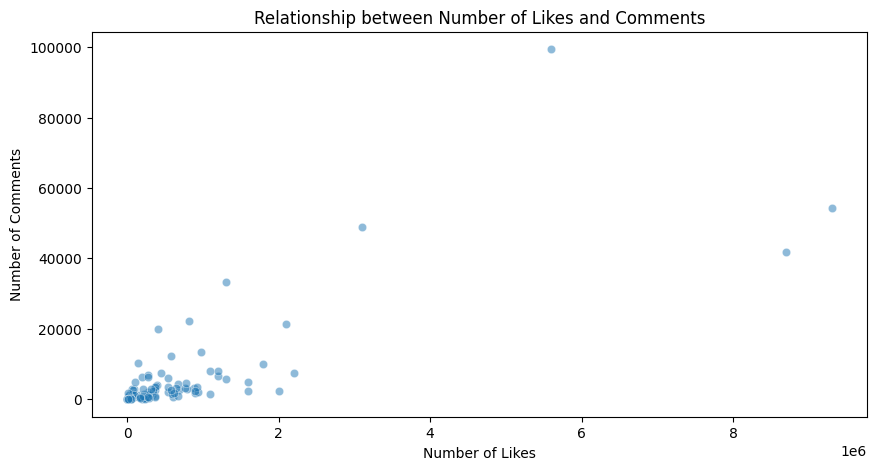

In [59]:
# plotting relationship between number of fans and number of total likes -- should be pretty intuitive, the more likes the better the engagement
plt.figure(figsize = (10,5))
sns.scatterplot(x = 'Likes', y = 'Comments', data = df, alpha = 0.5)
plt.xlabel('Number of Likes')
plt.ylabel('Number of Comments')
plt.title('Relationship between Number of Likes and Comments')
plt.show()

### Sentiment Analysis

In [60]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.tokenize import word_tokenize, PunktSentenceTokenizer
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
def custom_word_tokenize(text): # no idea why but word_tokenize is not working -- make a custom function that does almost the same thing
    tokenizer = PunktSentenceTokenizer()
    sentences = tokenizer.tokenize(text)
    words = []
    for sentence in sentences:
        words.extend(sentence.split())
    return words

In [62]:
# preprocess the title texts

def preprocess_text(text):
    if isinstance(text, str):
        # convert all to lowercase
        text = text.lower()
        
        # remove punctuation and all special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub('\W', ' ', text)
        text = re.sub('\s+', ' ', text).strip()

        # tokenizing the text -- segmenting text into vectors into numerical data structures (in this case, based on words)
        words = custom_word_tokenize(text)

        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]

        return ' '.join(words)
    
    else:
        return ''

In [63]:
sample_text = "This is a test sentence for preprocessing!"
print(preprocess_text(sample_text))

test sentence preprocessing


In [64]:
df['Cleaned_Title'] = df['Title'].apply(preprocess_text)
df.head()

,Title,Likes,Comments,Shares,Favorites,Cleaned_Title
0,Georgie Cooper is always surprising.🤣🤣🤣,2000000.0,2399.0,38900.0,143600.0,georgie cooper always surprising
1,Physics,22800.0,96.0,315.0,1164.0,physics
2,Man dumped via text for predicting election 💔🇺🇸🤣,1800000.0,10100.0,128300.0,104200.0,man dumped via text predicting election
3,Cops Get Destroyed For Unlawful Detainment! 1s...,85400.0,2973.0,915.0,6813.0,cops get destroyed unlawful detainment 1st ame...
4,Po’ baby 🥲,680900.0,2515.0,10600.0,16600.0,po baby


Get Sentiment Polarity with textblob

In [65]:
# create sentiment classification function using TextBlob
def sentiment_class(text): 
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    
    if sentiment < 0: 
        return 0 # negative sentiment detected
    else: 
        return 1 # positive sentiment

In [66]:
df['sentiment'] = df['Cleaned_Title'].apply(sentiment_class)
print(df.loc[:, ['Cleaned_Title', 'sentiment']])

                                         Cleaned_Title  sentiment
0                     georgie cooper always surprising          1
1                                              physics          1
2              man dumped via text predicting election          1
3    cops get destroyed unlawful detainment 1st ame...          1
4                                              po baby          1
..                                                 ...        ...
119                               shh dont tell anyone          1
120                                       3 nights row          1
121                                    sneaky students          1
122                   would swapped bodies best friend          1
123                                                             1

[124 rows x 2 columns]


In [67]:
print(df.loc[df['sentiment'] == 0, ['Cleaned_Title', 'sentiment']])

                                         Cleaned_Title  sentiment
5                                insane transformation          0
26                 350 razor blades forged sharp knife          0
29          anyone guess dangerous place united states          0
30                             casually walking tv set          0
31                    random restocks kitchen restocks          0
44                           kai stream insane tonight          0
50                 350 razor blades forged sharp knife          0
66                               seriously please stop          0
67                                yall think worst one          0
71                                          thats mean          0
97   notice barron trumps bodyguard must strictly o...          0
111                      scary sightings caught camera          0
114                                       cutting hair          0
115                                      think painful          0
116  wonde

In [68]:
sentiment_metrics = df.groupby('sentiment')[['Likes', 'Comments', 'Shares', 'Favorites']].mean()
print(sentiment_metrics) # 370k more likes on average

                   Likes     Comments        Shares     Favorites
sentiment                                                        
0          268097.066667  1627.533333  22157.000000  22477.133333
1          634872.220183  5217.440367  70154.266055  39719.495413


### Sentiment Statistical Analysis

Hypothesis: TikTok videos with a positive title sentiment receive more Likes than those with a negative or neutral sentiment.

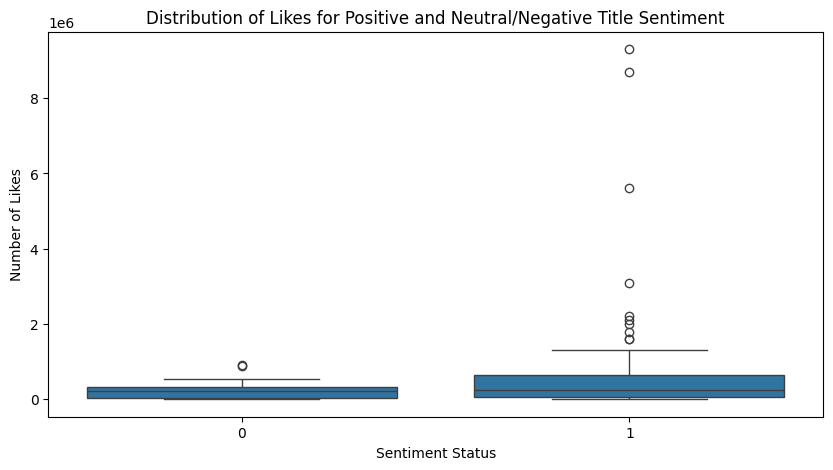

In [69]:
# plot the results with a boxplot
plt.figure(figsize = (10,5))
sns.boxplot(x = 'sentiment', y = 'Likes', data = df)
plt.xlabel('Sentiment Status')
plt.ylabel('Number of Likes')
plt.title('Distribution of Likes for Positive and Neutral/Negative Title Sentiment')
#plt.yscale('log')
plt.show() 
# generally speaking, there are more outliers in the non-verified status - this checks out

In [70]:
from scipy.stats import ttest_ind

In [71]:
positive_likes = df[df['sentiment'] == 1]['Likes']
negative_likes = df[df['sentiment'] == 0]['Likes']
t_statistic, p_value = ttest_ind(positive_likes, negative_likes, equal_var = False)
t_statistic, p_value # 0.017 p-value is significantly low -- positive sentiment captions get more likes

(2.4190932391530366, 0.01731612818922585)

The t-statistic is approximately 2.42 - over 2 standard deviations difference in means - and the p-value is approximately 0.017.

A smaller p-value indicates stronger evidence against the null hypothesis. In this case, the p-value being small (0.017), indicates strong evidence that the difference in means is not due to random chance.

The results of the t-test suggest that there is a statistically significant difference in the number of views between positive and negative/neutral sentiment videos, with positive sentiment videos receiving more views on average.